In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import scipy
from teeplot import teeplot as tp


In [2]:
teeplot_subdir = "adaptive-evolution-rate-nodirect.ipynb"


In [3]:
def load_and_process(url: str, mutation: str) -> pl.DataFrame:
    df = pl.read_parquet(
        url,
        use_pyarrow=True,
    ).with_columns(
        pl.col("SLIP_INSERTION_BOOL_MASK").any().over(
            ["Treatment", "Run ID", "Generation Born"],
        ).alias("SLIP_INSERTION_BOOL_MASK any"),
    ).group_by(
        ["Task", "Treatment", "Run ID", "Generation Born"],
    ).first().with_columns(
        pl.col("Task").replace_strict(
            {
                "AND": 2,
                "ANDNOT": 3,
                "NAND": 1,
                "NOR": 4,
                "NOT": 1,
                "OR": 3,
                "ORNOT": 2,
                "XOR": 4,
                "EQUALS": 5,
            },
        ).alias("Components"),
        pl.lit(mutation).alias("Mutation"),
    )

    return df


In [4]:
df1 = load_and_process("https://osf.io/emh23/download", "poisson")


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


In [5]:
df2 = load_and_process("https://osf.io/gk2ty/download", "per site")


In [6]:
df = pl.concat([df1, df2])
df


Task,Treatment,Run ID,Generation Born,Genome Length,Lineage Generation Index,Is Task Coding Site,Is Viability Site,Is Task Coding Site Cumulative Count,Is Viability Site Cumulative Count,Prev Is Task Coding Site Cumulative Count,Prev Is Viability Site Cumulative Count,Prev Is Task Coding Site,Prev Is Viability Site,Site,Has Task,has task,delta has task,Delta Has Task,CHILD_SOURCE_MAP,POINT_MUTATION_BOOL_MASK,SLIP_INSERTION_ORIGIN_BOOL_MASK,SLIP_INSERTION_RESULT_BOOL_MASK,GENOME_CHARACTERS,Is Task Coding Site Delta,Is Viability Site Delta,Point Mutation Cumulative Count,Slip Insertion Cumulative Count,Prev Slip Insertion Cumulative Count,SLIP_INSERTION_BOOL_MASK,Update Born,SLIP_INSERTION_BOOL_MASK any,Components,Mutation
cat,cat,cat,u16,i64,u16,bool,bool,i16,i16,i16,i16,bool,bool,u16,bool,bool,i8,i8,i16,bool,bool,bool,cat,i8,i8,u16,u16,u16,bool,i32,bool,i64,str
"""ANDNOT""","""Slip-""","""run_1814""",268,169,60,false,false,0,27,0,27,false,false,0,false,false,0,0,0,false,false,false,"""a""",0,0,1,3,3,false,2831,true,3,"""poisson"""
"""OR""","""Slip-_Long""","""run_1784""",123,1000,14,false,true,0,15,0,14,false,true,0,false,false,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,14858,false,3,"""poisson"""
"""ORNOT""","""Slip-""","""run_1817""",5032,105,183,false,true,0,168,0,167,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,34850,false,2,"""poisson"""
"""XOR""","""Slip-""","""run_1802""",6523,104,450,false,false,0,91,0,91,false,false,0,false,false,0,0,0,false,false,false,"""o""",0,0,24,2,2,false,42828,true,4,"""poisson"""
"""NAND""","""Slip-""","""run_1816""",6508,110,277,false,false,0,270,0,270,false,false,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,44650,true,1,"""poisson"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""NOR""","""Slip-duplicate""","""run_1610""",582,624,74,false,true,0,75,0,74,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,11216,false,4,"""per site"""
"""ORNOT""","""Baseline-Treatment""","""run_1537""",542,100,41,false,true,0,42,0,41,false,true,0,false,false,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,5956,false,2,"""per site"""
"""NOT""","""Baseline-Treatment""","""run_1555""",819,100,51,false,true,0,52,0,51,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,7705,false,1,"""per site"""


In [7]:
df = df.with_columns(
    (
        pl.col("Generation Born")
        + 0 / pl.col("has task")
    ).min().over(
        ["Treatment", "Run ID", "Mutation", "Task"],
    ).alias("First Task Generation"),
    pl.col("Generation Born").max().over(
        ["Treatment", "Run ID", "Mutation"]
    ).alias("Last Generation"),
)
df


Task,Treatment,Run ID,Generation Born,Genome Length,Lineage Generation Index,Is Task Coding Site,Is Viability Site,Is Task Coding Site Cumulative Count,Is Viability Site Cumulative Count,Prev Is Task Coding Site Cumulative Count,Prev Is Viability Site Cumulative Count,Prev Is Task Coding Site,Prev Is Viability Site,Site,Has Task,has task,delta has task,Delta Has Task,CHILD_SOURCE_MAP,POINT_MUTATION_BOOL_MASK,SLIP_INSERTION_ORIGIN_BOOL_MASK,SLIP_INSERTION_RESULT_BOOL_MASK,GENOME_CHARACTERS,Is Task Coding Site Delta,Is Viability Site Delta,Point Mutation Cumulative Count,Slip Insertion Cumulative Count,Prev Slip Insertion Cumulative Count,SLIP_INSERTION_BOOL_MASK,Update Born,SLIP_INSERTION_BOOL_MASK any,Components,Mutation,First Task Generation,Last Generation
cat,cat,cat,u16,i64,u16,bool,bool,i16,i16,i16,i16,bool,bool,u16,bool,bool,i8,i8,i16,bool,bool,bool,cat,i8,i8,u16,u16,u16,bool,i32,bool,i64,str,f64,u16
"""ANDNOT""","""Slip-""","""run_1814""",268,169,60,false,false,0,27,0,27,false,false,0,false,false,0,0,0,false,false,false,"""a""",0,0,1,3,3,false,2831,true,3,"""poisson""",1666.0,2050
"""OR""","""Slip-_Long""","""run_1784""",123,1000,14,false,true,0,15,0,14,false,true,0,false,false,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,14858,false,3,"""poisson""",NaN,389
"""ORNOT""","""Slip-""","""run_1817""",5032,105,183,false,true,0,168,0,167,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,34850,false,2,"""poisson""",144.0,7376
"""XOR""","""Slip-""","""run_1802""",6523,104,450,false,false,0,91,0,91,false,false,0,false,false,0,0,0,false,false,false,"""o""",0,0,24,2,2,false,42828,true,4,"""poisson""",NaN,7701
"""NAND""","""Slip-""","""run_1816""",6508,110,277,false,false,0,270,0,270,false,false,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,44650,true,1,"""poisson""",177.0,7220
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""NOR""","""Slip-duplicate""","""run_1610""",582,624,74,false,true,0,75,0,74,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,11216,false,4,"""per site""",427.0,1263
"""ORNOT""","""Baseline-Treatment""","""run_1537""",542,100,41,false,true,0,42,0,41,false,true,0,false,false,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,5956,false,2,"""per site""",693.0,5590
"""NOT""","""Baseline-Treatment""","""run_1555""",819,100,51,false,true,0,52,0,51,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,7705,false,1,"""per site""",81.0,5099


In [8]:
df.group_by(
    ["Treatment", "Mutation"],
).agg(
    pl.col("Last Generation").min(),
)


Treatment,Mutation,Last Generation
cat,str,u16
"""Slip-""","""poisson""",2050
"""Long-Ancestor-Control-Treatmen…","""per site""",538
"""Baseline-Treatment""","""per site""",4081
"""Slip+""","""poisson""",573
"""Slip-duplicate""","""per site""",901
"""Slip-_Long""","""poisson""",340


In [9]:
least_last_generation = 600
least_last_generation


600

In [10]:
dfz = df.filter(
    # (pl.col("Generation Born") <= least_last_generation)
    pl.col("has task")
    & (pl.col("delta has task") == 1)
    & (pl.col("First Task Generation") == pl.col("Generation Born"))
    & (
        (pl.col("Treatment") != "Slip-duplicate")
        | (~pl.col("SLIP_INSERTION_BOOL_MASK any"))
    )
).group_by(
    ["Task", "Treatment", "Run ID", "Components", "Mutation"],
).agg(
    pl.col("Generation Born").min(),
)
dfz


Task,Treatment,Run ID,Components,Mutation,Generation Born
cat,cat,cat,i64,str,u16
"""ANDNOT""","""Baseline-Treatment""","""run_1543""",3,"""per site""",239
"""NAND""","""Slip-_Long""","""run_1771""",1,"""poisson""",335
"""NAND""","""Slip+""","""run_1831""",1,"""poisson""",148
"""NOT""","""Long-Ancestor-Control-Treatmen…","""run_1748""",1,"""per site""",34
"""ORNOT""","""Long-Ancestor-Control-Treatmen…","""run_1759""",2,"""per site""",107
…,…,…,…,…,…
"""NOT""","""Baseline-Treatment""","""run_1553""",1,"""per site""",204
"""AND""","""Baseline-Treatment""","""run_1547""",2,"""per site""",824
"""XOR""","""Long-Ancestor-Control-Treatmen…","""run_1748""",4,"""per site""",589


In [11]:
dfz


Task,Treatment,Run ID,Components,Mutation,Generation Born
cat,cat,cat,i64,str,u16
"""ANDNOT""","""Baseline-Treatment""","""run_1543""",3,"""per site""",239
"""NAND""","""Slip-_Long""","""run_1771""",1,"""poisson""",335
"""NAND""","""Slip+""","""run_1831""",1,"""poisson""",148
"""NOT""","""Long-Ancestor-Control-Treatmen…","""run_1748""",1,"""per site""",34
"""ORNOT""","""Long-Ancestor-Control-Treatmen…","""run_1759""",2,"""per site""",107
…,…,…,…,…,…
"""NOT""","""Baseline-Treatment""","""run_1553""",1,"""per site""",204
"""AND""","""Baseline-Treatment""","""run_1547""",2,"""per site""",824
"""XOR""","""Long-Ancestor-Control-Treatmen…","""run_1748""",4,"""per site""",589


In [12]:
maxgen = dfz["Generation Born"].max()

records = []
records2 = set()
for row in dfz.iter_rows(named=True):
    records.append(
        pd.DataFrame(
            {
                "Task": row["Task"],
                "Treatment": row["Treatment"],
                "Run ID": row["Run ID"],
                "Generation": np.arange(maxgen),
                "Components": row["Components"],
                "Has Task":  row["Generation Born"] <= np.arange(maxgen),
                "mutation": row["Mutation"],
            },
        ),
    )
    records2.add(
        (row["Run ID"], row["Treatment"], row["Task"], row["Components"], row["Mutation"]),
    )

for v, grp in df.to_pandas().groupby(
    ["Run ID", "Treatment", "Task", "Components", "Mutation"],
    observed=True,
):
    if v not in records2:
        print(v)
        records.append(
            pd.DataFrame(
                {
                    "Task": v[2],
                    "Treatment": v[1],
                    "Run ID": v[0],
                    "Components": v[3],
                    "Generation": np.arange(maxgen),
                    "Has Task":  False,
                    "mutation": v[4],
                },
            ),
        )

dfz_ = pd.concat(records, ignore_index=True)


('run_1770', 'Slip-_Long', 'ANDNOT', np.int64(3), 'poisson')
('run_1770', 'Slip-_Long', 'EQUALS', np.int64(5), 'poisson')
('run_1770', 'Slip-_Long', 'NOR', np.int64(4), 'poisson')
('run_1770', 'Slip-_Long', 'XOR', np.int64(4), 'poisson')
('run_1771', 'Slip-_Long', 'AND', np.int64(2), 'poisson')
('run_1771', 'Slip-_Long', 'ANDNOT', np.int64(3), 'poisson')
('run_1771', 'Slip-_Long', 'EQUALS', np.int64(5), 'poisson')
('run_1771', 'Slip-_Long', 'NOR', np.int64(4), 'poisson')
('run_1771', 'Slip-_Long', 'OR', np.int64(3), 'poisson')
('run_1771', 'Slip-_Long', 'XOR', np.int64(4), 'poisson')
('run_1772', 'Slip-_Long', 'AND', np.int64(2), 'poisson')
('run_1772', 'Slip-_Long', 'ANDNOT', np.int64(3), 'poisson')
('run_1772', 'Slip-_Long', 'EQUALS', np.int64(5), 'poisson')
('run_1772', 'Slip-_Long', 'NOR', np.int64(4), 'poisson')
('run_1772', 'Slip-_Long', 'NOT', np.int64(1), 'poisson')
('run_1772', 'Slip-_Long', 'OR', np.int64(3), 'poisson')
('run_1772', 'Slip-_Long', 'XOR', np.int64(4), 'poisson'

('run_1808', 'Slip-', 'NOR', np.int64(4), 'poisson')
('run_1808', 'Slip-', 'XOR', np.int64(4), 'poisson')
('run_1810', 'Slip-', 'AND', np.int64(2), 'poisson')
('run_1810', 'Slip-', 'ANDNOT', np.int64(3), 'poisson')
('run_1810', 'Slip-', 'EQUALS', np.int64(5), 'poisson')
('run_1810', 'Slip-', 'XOR', np.int64(4), 'poisson')
('run_1811', 'Slip-', 'EQUALS', np.int64(5), 'poisson')
('run_1811', 'Slip-', 'XOR', np.int64(4), 'poisson')
('run_1812', 'Slip-', 'EQUALS', np.int64(5), 'poisson')
('run_1812', 'Slip-', 'NOR', np.int64(4), 'poisson')
('run_1812', 'Slip-', 'XOR', np.int64(4), 'poisson')
('run_1813', 'Slip-', 'NOR', np.int64(4), 'poisson')
('run_1814', 'Slip-', 'EQUALS', np.int64(5), 'poisson')
('run_1814', 'Slip-', 'OR', np.int64(3), 'poisson')
('run_1814', 'Slip-', 'XOR', np.int64(4), 'poisson')
('run_1815', 'Slip-', 'EQUALS', np.int64(5), 'poisson')
('run_1815', 'Slip-', 'XOR', np.int64(4), 'poisson')
('run_1816', 'Slip-', 'EQUALS', np.int64(5), 'poisson')
('run_1816', 'Slip-', 'XOR

('run_1614', 'Slip-duplicate', 'ANDNOT', np.int64(3), 'per site')
('run_1614', 'Slip-duplicate', 'EQUALS', np.int64(5), 'per site')
('run_1614', 'Slip-duplicate', 'NOT', np.int64(1), 'per site')
('run_1614', 'Slip-duplicate', 'ORNOT', np.int64(2), 'per site')
('run_1614', 'Slip-duplicate', 'XOR', np.int64(4), 'per site')
('run_1615', 'Slip-duplicate', 'EQUALS', np.int64(5), 'per site')
('run_1615', 'Slip-duplicate', 'NOR', np.int64(4), 'per site')
('run_1615', 'Slip-duplicate', 'ORNOT', np.int64(2), 'per site')
('run_1616', 'Slip-duplicate', 'NAND', np.int64(1), 'per site')
('run_1617', 'Slip-duplicate', 'EQUALS', np.int64(5), 'per site')
('run_1617', 'Slip-duplicate', 'NAND', np.int64(1), 'per site')
('run_1618', 'Slip-duplicate', 'NOR', np.int64(4), 'per site')
('run_1618', 'Slip-duplicate', 'XOR', np.int64(4), 'per site')
('run_1619', 'Slip-duplicate', 'NOR', np.int64(4), 'per site')
('run_1740', 'Long-Ancestor-Control-Treatment', 'EQUALS', np.int64(5), 'per site')
('run_1740', 'Lon

teeplots/adaptive-evolution-rate-nodirect.ipynb/col=task+errorbar=ci+hue=treatment+kind=line+post=plt-xlim-0-600+row=mutation+viz=relplot+x=generation+y=has-task+ext=.pdf


teeplots/adaptive-evolution-rate-nodirect.ipynb/col=task+errorbar=ci+hue=treatment+kind=line+post=plt-xlim-0-600+row=mutation+viz=relplot+x=generation+y=has-task+ext=.png


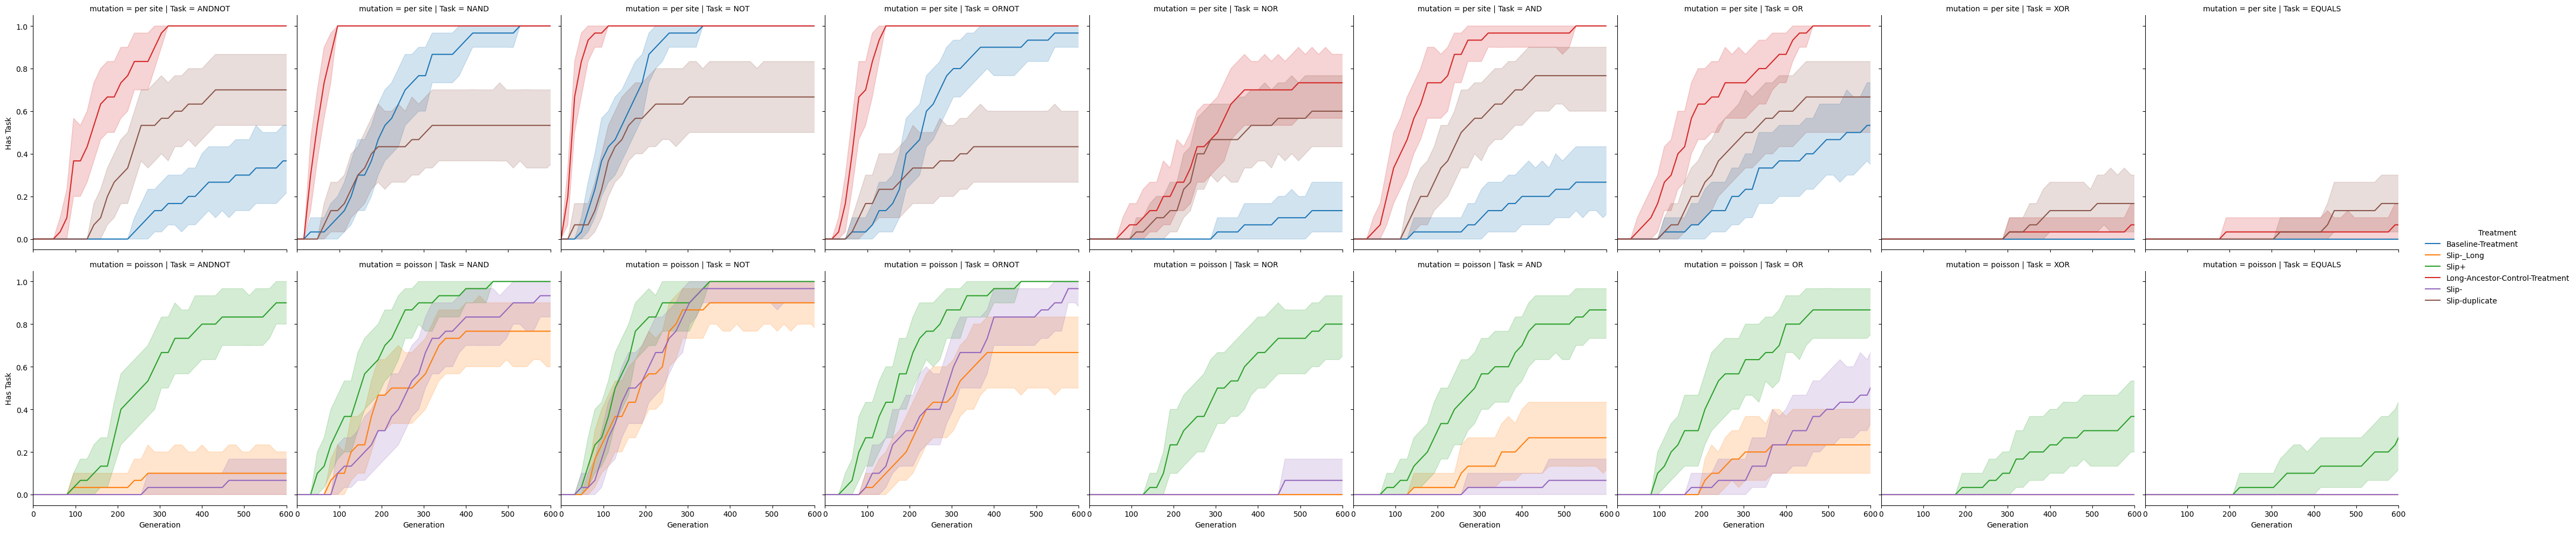

In [13]:
tp.tee(
    sns.relplot,
    data=dfz_[
        dfz_["Generation"] % 16 == 0
    ].reset_index(),
    col="Task",
    row="mutation",
    x="Generation",
    y="Has Task",
    hue="Treatment",
    kind="line",
    # teeplot_postprocess='plt.xscale("log")',
    teeplot_postprocess=f'plt.xlim(0, {least_last_generation})',
    teeplot_subdir=teeplot_subdir,
    errorbar="ci",
)


teeplots/adaptive-evolution-rate-nodirect.ipynb/col=components+errorbar=ci+hue=treatment+kind=line+post=plt-xlim-0-600+row=mutation+viz=relplot+x=generation+y=has-task+ext=.pdf


teeplots/adaptive-evolution-rate-nodirect.ipynb/col=components+errorbar=ci+hue=treatment+kind=line+post=plt-xlim-0-600+row=mutation+viz=relplot+x=generation+y=has-task+ext=.png


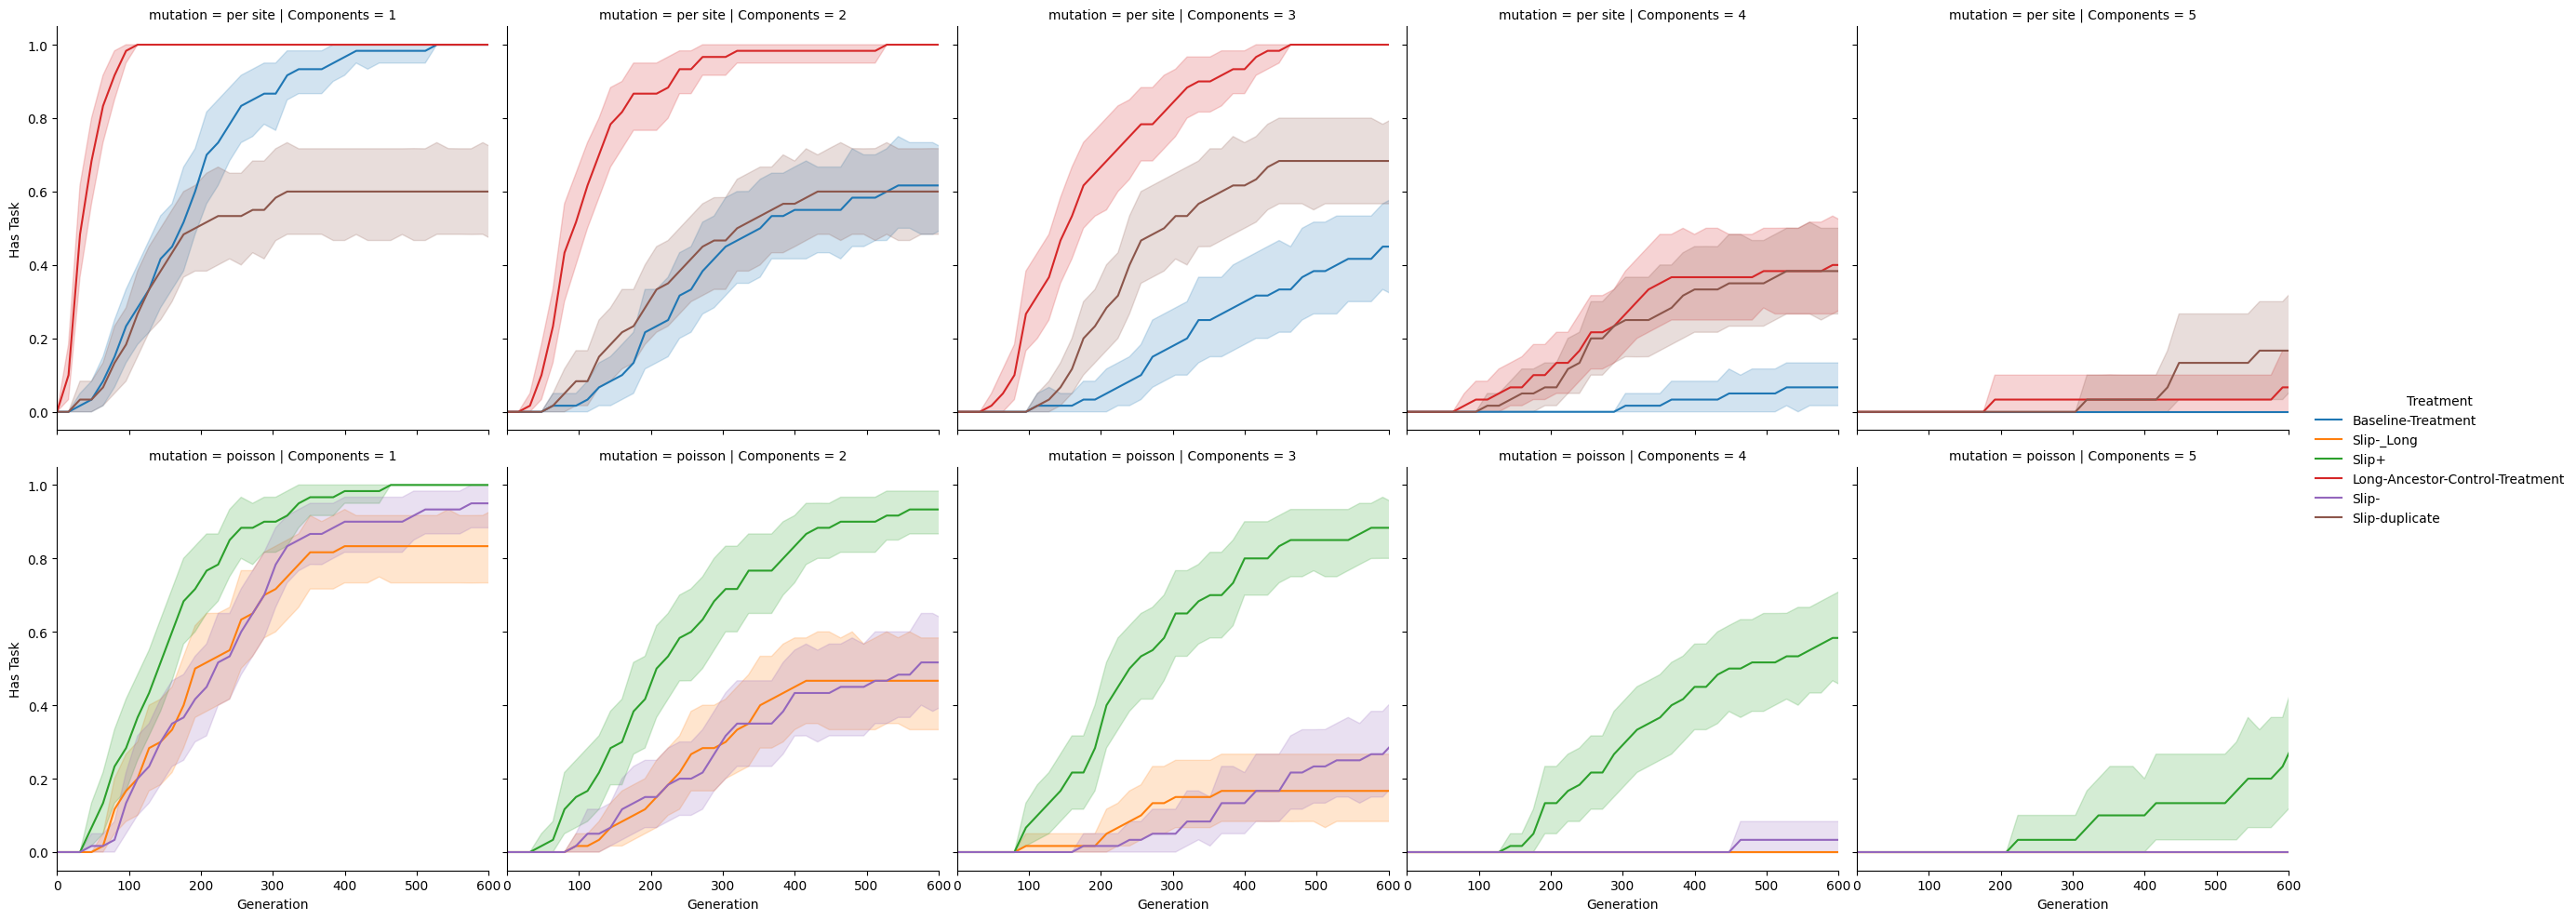

In [14]:
tp.tee(
    sns.relplot,
    data=dfz_[
        dfz_["Generation"] % 16 == 0
    ].reset_index(),
    col="Components",
    row="mutation",
    x="Generation",
    y="Has Task",
    hue="Treatment",
    kind="line",
    teeplot_postprocess=f"plt.xlim(0, {least_last_generation})",
    teeplot_subdir=teeplot_subdir,
    errorbar="ci",
)


In [15]:
fil = dfz_[
    (dfz_["Generation"] == 599)
]

for task in fil["Task"].unique():
    tab = [
        [
            (
                (fil["Treatment"] == "Baseline-Treatment")
                & (fil["Task"] == task)
                & fil["Has Task"]
            ).sum(),
            (
                (fil["Treatment"] == "Slip-duplicate")
                & (fil["Task"] == task)
                & fil["Has Task"]
            ).sum(),
        ],
        [
            (
                (fil["Treatment"] == "Baseline-Treatment")
                & (fil["Task"] == task)
                & (~fil["Has Task"])
            ).sum(),
            (
                (fil["Treatment"] == "Slip-duplicate")
                & (fil["Task"] == task)
                & (~fil["Has Task"])
            ).sum(),
        ],
    ]
    print(task, tab)
    print("    ", scipy.stats.fisher_exact(tab))


ANDNOT [[np.int64(11), np.int64(21)], [np.int64(19), np.int64(9)]]
     SignificanceResult(statistic=np.float64(0.24812030075187969), pvalue=np.float64(0.019096056845063346))
NAND [[np.int64(30), np.int64(16)], [np.int64(0), np.int64(14)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(1.6767384375519427e-05))
NOT [[np.int64(30), np.int64(20)], [np.int64(0), np.int64(10)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(0.0007970131314101389))
ORNOT [[np.int64(29), np.int64(13)], [np.int64(1), np.int64(17)]]
     SignificanceResult(statistic=np.float64(37.92307692307692), pvalue=np.float64(7.954964600623303e-06))
NOR [[np.int64(4), np.int64(18)], [np.int64(26), np.int64(12)]]
     SignificanceResult(statistic=np.float64(0.10256410256410256), pvalue=np.float64(0.00036817673390080477))
AND [[np.int64(8), np.int64(23)], [np.int64(22), np.int64(7)]]
     SignificanceResult(statistic=np.float64(0.11067193675889328), pvalue=np.float64(0.00023089337753119202))
OR [[np.int64

In [16]:
fil = dfz_[
    (dfz_["Generation"] == 599)
]

for task in fil["Task"].unique():
    tab = [
        [
            (
                (fil["Treatment"] == "Long-Ancestor-Control-Treatment")
                & (fil["Task"] == task)
                & fil["Has Task"]
            ).sum(),
            (
                (fil["Treatment"] == "Slip-duplicate")
                & (fil["Task"] == task)
                & fil["Has Task"]
            ).sum(),
        ],
        [
            (
                (fil["Treatment"] == "Long-Ancestor-Control-Treatment")
                & (fil["Task"] == task)
                & (~fil["Has Task"])
            ).sum(),
            (
                (fil["Treatment"] == "Slip-duplicate")
                & (fil["Task"] == task)
                & (~fil["Has Task"])
            ).sum(),
        ],
    ]
    print(task, tab)
    print("    ", scipy.stats.fisher_exact(tab))


ANDNOT [[np.int64(30), np.int64(21)], [np.int64(0), np.int64(9)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(0.001935603319138909))
NAND [[np.int64(30), np.int64(16)], [np.int64(0), np.int64(14)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(1.6767384375519427e-05))
NOT [[np.int64(30), np.int64(20)], [np.int64(0), np.int64(10)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(0.0007970131314101389))
ORNOT [[np.int64(30), np.int64(13)], [np.int64(0), np.int64(17)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(6.185596344065137e-07))
NOR [[np.int64(22), np.int64(18)], [np.int64(8), np.int64(12)]]
     SignificanceResult(statistic=np.float64(1.8333333333333333), pvalue=np.float64(0.41175659704810597))
AND [[np.int64(30), np.int64(23)], [np.int64(0), np.int64(7)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(0.010542535074203227))
OR [[np.int64(30), np.int64(20)], [np.int64(0), np.int64(10)]]
     SignificanceResult(statistic=inf, 

In [17]:
fil = dfz_[
    (dfz_["Generation"] == 599)
]

for components in sorted(fil["Components"].unique()):
    tab = [
        [
            (
                (fil["Treatment"] == "Long-Ancestor-Control-Treatment")
                & (fil["Components"] == components)
                & fil["Has Task"]
            ).sum(),
            (
                (fil["Treatment"] == "Slip-duplicate")
                & (fil["Components"] == components)
                & fil["Has Task"]
            ).sum(),
        ],
        [
            (
                (fil["Treatment"] == "Long-Ancestor-Control-Treatment")
                & (fil["Components"] == components)
                & (~fil["Has Task"])
            ).sum(),
            (
                (fil["Treatment"] == "Slip-duplicate")
                & (fil["Components"] == components)
                & (~fil["Has Task"])
            ).sum(),
        ],
    ]
    print(components, tab)
    print("    ", scipy.stats.fisher_exact(tab))


1 [[np.int64(60), np.int64(36)], [np.int64(0), np.int64(24)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(6.632030256515911e-09))
2 [[np.int64(60), np.int64(36)], [np.int64(0), np.int64(24)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(6.632030256515911e-09))
3 [[np.int64(60), np.int64(41)], [np.int64(0), np.int64(19)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(7.009823797510181e-07))
4 [[np.int64(24), np.int64(23)], [np.int64(36), np.int64(37)]]
     SignificanceResult(statistic=np.float64(1.0724637681159421), pvalue=1.0)
5 [[np.int64(2), np.int64(5)], [np.int64(28), np.int64(25)]]
     SignificanceResult(statistic=np.float64(0.35714285714285715), pvalue=np.float64(0.4238099099829697))
